In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets.csv')

data.shape

(746, 10)

In [35]:
# Remove any 'w' if it exists
data['Time'] = data['Time'].str.replace('w', '', regex=False)

# Then parse properly
data['Time'] = pd.to_datetime(data['Time'] + '-1', format='%Y-%W-%w')

# Set Time as index
data.set_index('Time', inplace=True)

data.head()

,Rainfall,MaxTemperature,Humidity,Cases,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
Time,,,,,,,,,
2011-01-03,9.938571,29.444400,86.242857,5,NaN,NaN,NaN,NaN,NaN
2011-01-10,8.587143,30.000000,88.028571,4,NaN,NaN,NaN,NaN,NaN
2011-01-17,5.338571,30.000000,84.028571,2,NaN,NaN,NaN,NaN,NaN
2011-01-24,5.410000,30.555556,80.971429,7,NaN,NaN,NaN,NaN,NaN
2011-01-31,2.914286,28.333333,74.885714,2,NaN,NaN,NaN,NaN,NaN


In [36]:
# Select features for normalization (excluding the target column)
features = data[['Rainfall', 'MaxTemperature','Humidity']]
target = data['Cases']

features.shape, target.shape

# Normalize the features and target using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

normalized_features = scaler_features.fit_transform(features)
normalized_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Convert back to DataFrame for better manipulation
normalized_data = pd.DataFrame(normalized_features, columns=features.columns, index=data.index)
normalized_data['Cases'] = normalized_target

In [37]:
# Function to create sequences for LSTM
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(target[i])
    return np.array(X), np.array(y)

def build_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    # Tune the number of LSTM units
    model.add(LSTM(units=64, activation='relu'))

    # Output layer
    model.add(Dense(1))

    # Tune the learning rate
    lr = 0.01
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model

In [38]:
# Extract the year from the index
data['Year'] = data.index.year

# Separate into train (2011-2024) and test (2025)
train_data = normalized_data[data.index.year < 2025]
test_data = normalized_data[data.index.year == 2025]

# Create sequences for both sets
window_size = 5
X_train, y_train = create_sequences(train_data.values, train_data['Cases'].values.reshape(-1, 1), window_size)
X_test, y_test = create_sequences(test_data.values, test_data['Cases'].values.reshape(-1, 1), window_size)


In [39]:
# Build model
model = build_model()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit on train set
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=1,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

# Predict on 2025
y_pred_test = model.predict(X_test, verbose=0)

# Inverse transform
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_test_predicted = scaler_target.inverse_transform(y_pred_test.reshape(-1, 1))

# Metrics
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_predicted))
test_mae = mean_absolute_error(y_test_actual, y_test_predicted)
test_r2 = r2_score(y_test_actual, y_test_predicted)

print(f"2025 Test RMSE: {test_rmse:.4f}")
print(f"2025 Test MAE: {test_mae:.4f}")
print(f"2025 Test R²: {test_r2:.4f}")


Epoch 1/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0154 - val_loss: 0.0055
Epoch 2/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 3/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 4/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0018 - val_loss: 0.0102
Epoch 5/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 6/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 7/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 8/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 9/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 10/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 11/100
578/578 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 12/100
578/578 ━━━━━━━━━━━━━━━━━━━━

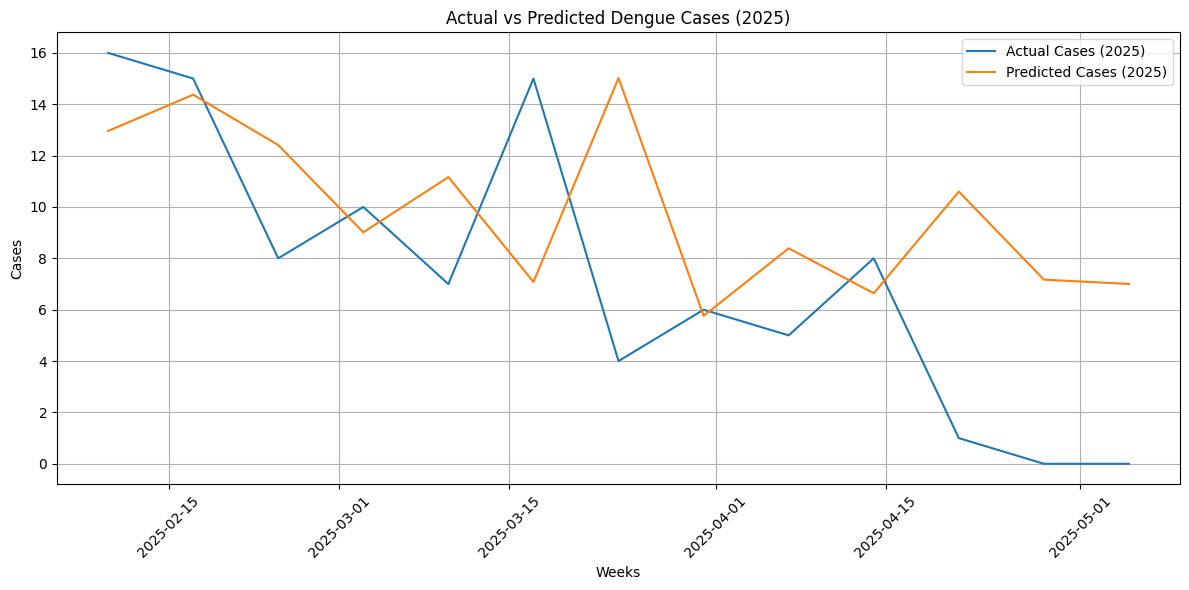

In [40]:
# Create an array for weeks
weeks = test_data.index[window_size:]  # Since we lose 'window_size' rows during sequence creation

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(weeks, y_test_actual, label='Actual Cases (2025)')
plt.plot(weeks, y_test_predicted, label='Predicted Cases (2025)')
plt.title('Actual vs Predicted Dengue Cases (2025)')
plt.xlabel('Weeks')
plt.ylabel('Cases')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
